# **Import the Libraries**

In [19]:
# Document Collection, Tokenizer, Normalization Pipeline on IMDB dataset
import os
import tarfile
import random
import pandas as pd
import numpy as np
import nltk
import logging
import time
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
nltk.download('punkt')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mamta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mamta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mamta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **STEP 1: LOADING AND PREPROCESSING**

## Load the Dataset

In [20]:
# --- Use TensorFlow Datasets to load IMDB ---
import tensorflow as tf
import tensorflow_datasets as tfds

# Load IMDB reviews dataset from TensorFlow Datasets
# as_supervised=True gives (text, label) pairs
(ds_train, ds_test), ds_info = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

# --- Step 2: Collect 1000 positive + 1000 negative from the training split ---

documents = []
pos_count = 0
neg_count = 0
TARGET_PER_CLASS = 1000

# Convert TFDS dataset to NumPy for easy iteration
for text, label in tfds.as_numpy(ds_train.shuffle(25000, seed=42)):
    text_str = text.decode("utf-8")
    label_int = int(label)

    if label_int == 1 and pos_count < TARGET_PER_CLASS:
        documents.append((text_str, "positive"))
        pos_count += 1
    elif label_int == 0 and neg_count < TARGET_PER_CLASS:
        documents.append((text_str, "negative"))
        neg_count += 1

    if pos_count >= TARGET_PER_CLASS and neg_count >= TARGET_PER_CLASS:
        break

print(f"Collected {pos_count} positive and {neg_count} negative reviews.")

# Shuffle the dataset
random.shuffle(documents)

# Convert to pandas DataFrame
df = pd.DataFrame(documents, columns=["text", "label"])
df.head()

2025-12-08 14:01:22,858 : INFO : No config specified, defaulting to config: imdb_reviews/plain_text
2025-12-08 14:01:22,862 : INFO : Load dataset info from C:\Users\mamta\tensorflow_datasets\imdb_reviews\plain_text\1.0.0
2025-12-08 14:01:22,869 : INFO : Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\mamta\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.
2025-12-08 14:01:22,925 : INFO : Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\mamta\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.
2025-12-08 14:01:22,977 : INFO : Constructing tf.data.Dataset imdb_reviews for split ['train', 'test'], from C:\Users\mamta\tensorflow_datasets\imdb_reviews\plain_text\1.0.0


Collected 1000 positive and 1000 negative reviews.


,text,label
0,"This is one of those movies - like Dave, Ameri...",positive
1,I love cinema so what I'm about to confess emb...,positive
2,"I recently bought the DVD, forgetting just how...",negative
3,"Yeah, that about sums it up. This movie was ho...",negative
4,"Although this was not without its faults, this...",positive


## Data Distribution Exploration

In [21]:
print("Dataset shape:", df.shape)
print("\nLabel distribution:")
print(df['label'].value_counts())

df[['text', 'label']].head()


Dataset shape: (2000, 2)

Label distribution:
label
positive    1000
negative    1000
Name: count, dtype: int64


,text,label
0,"This is one of those movies - like Dave, Ameri...",positive
1,I love cinema so what I'm about to confess emb...,positive
2,"I recently bought the DVD, forgetting just how...",negative
3,"Yeah, that about sums it up. This movie was ho...",negative
4,"Although this was not without its faults, this...",positive


## Tokenization

In [22]:
first_review = df.loc[0, "text"]
first_review_tokens = word_tokenize(first_review)

print("=== FIRST REVIEW (text sample) ===")
print(first_review[:300], "...")

print("\n=== TOKENIZED OUTPUT ===")
print(first_review_tokens[:30])


=== FIRST REVIEW (text sample) ===
This is one of those movies - like Dave, American Dreamer and Local Hero - that holds a viewer's interest time and again. Lightweight movies seldom win Oscars, but whoever did the casting for Soapdish deserves one. Even after one has seen the movie and knows what is coming, it's still enjoyable to w ...

=== TOKENIZED OUTPUT ===
['This', 'is', 'one', 'of', 'those', 'movies', '-', 'like', 'Dave', ',', 'American', 'Dreamer', 'and', 'Local', 'Hero', '-', 'that', 'holds', 'a', 'viewer', "'s", 'interest', 'time', 'and', 'again', '.', 'Lightweight', 'movies', 'seldom', 'win']


## Normalization and Stopwords removal

In [23]:
def normalize_and_remove_stops(tokens):
    """
    1. Converts all tokens to lowercase (Normalization).
    2. Removes common English stop words.
    """
    # 1. Normalization: Convert to lowercase
    normalized_tokens = [token.lower() for token in tokens]

    # 2. Stop Words Removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in normalized_tokens if token not in stop_words]
    
    return filtered_tokens

# Process our IMDB review tokens
cleaned_tokens = normalize_and_remove_stops(first_review_tokens)

print("--- NORMALIZATION & STOP WORDS REMOVAL ---")
print(cleaned_tokens[:30])


--- NORMALIZATION & STOP WORDS REMOVAL ---
['one', 'movies', '-', 'like', 'dave', ',', 'american', 'dreamer', 'local', 'hero', '-', 'holds', 'viewer', "'s", 'interest', 'time', '.', 'lightweight', 'movies', 'seldom', 'win', 'oscars', ',', 'whoever', 'casting', 'soapdish', 'deserves', 'one', '.', 'even']


## Train-Test Split the Dataset

In [24]:
X = df["text"].values          # Raw review text
y = df["label"].values         # "Positive" / "Negative"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 1500
Test size : 500


# **STEP 2: TF-IDF FEATURE EXTRACTION ON IMDB REVIEWS**

## TF-IDF Vectorization

In [25]:
"""
TF-IDF (Term Frequency–Inverse Document Frequency) does:
- Term Frequency (TF): how often a word appears in a document.
- Inverse Document Frequency (IDF): down-weights words that appear in many documents.
Result: words that are frequent in a document but rare across the corpus get higher weights.
"""
vectorizer = TfidfVectorizer(
    max_features=5000,      # limit vocabulary size for practicality
    ngram_range=(1, 1),     # unigrams only for now
    lowercase=True,         # convert to lowercase
    stop_words='english'    # remove English stopwords
)

# Fit on training data only (to avoid data leakage)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("\n=== TF-IDF MATRIX INFO ===")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


=== TF-IDF MATRIX INFO ===
Train TF-IDF shape: (1500, 5000)
Test TF-IDF shape : (500, 5000)


## Vocabulary Inspection

In [26]:
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary size:", len(vocab))

print("\nSample of first 100 features:")
print(vocab[:100])


Vocabulary size: 5000

Sample of first 100 features:
['00' '000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '1922'
 '1930' '1930s' '1932' '1935' '1936' '1940' '1943' '1950' '1950s' '1960'
 '1969' '1970' '1970s' '1973' '1979' '1980' '1980s' '1983' '1985' '1990'
 '1990s' '1996' '1997' '1999' '1st' '20' '2000' '2001' '2002' '2003'
 '2004' '2005' '2006' '2008' '20th' '24' '25' '26' '27' '30' '30s' '35'
 '3rd' '40' '400' '50' '50s' '60' '60s' '70' '70s' '73' '80' '80s' '90'
 '90s' '99' '999' 'abandoned' 'abilities' 'ability' 'able' 'abraham'
 'abruptly' 'absolute' 'absolutely' 'absurd' 'abuse' 'abused' 'academic'
 'academy' 'accent' 'accents' 'accept' 'acceptable' 'accepted' 'access'
 'accident' 'accidentally' 'accompanied' 'accomplished' 'according'
 'account' 'accuracy' 'accurate' 'accurately']


## Inspect TF-IDF Weights for a Single Review

In [27]:
doc_index = 0  # first training document
doc_vector = X_train_tfidf[doc_index].toarray().ravel()

# Indices of top 10 highest-weighted terms in this document
top_indices = doc_vector.argsort()[::-1][:10]

print("\n=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===")
print("Original review snippet:")
print(X_train[doc_index][:300], "...")

print("\nTop 10 weighted terms:")
for idx in top_indices:
    term = vocab[idx]
    weight = doc_vector[idx]
    print(f"{term:<20} -> {weight:.4f}")


=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===
Original review snippet:
this movie had a lot of blood in it when the sabretooth attack it also i loved it when that guy and the women were having some good time and then the sabretooth attacked the women and ate her stomach and took the liver out. that was the best and the 1ton sabretooth walking on its front legs hilariou ...

Top 10 weighted terms:
sabretooth           -> 0.6157
women                -> 0.2664
stomach              -> 0.2522
movie                -> 0.2011
blood                -> 0.1906
loved                -> 0.1807
ending               -> 0.1631
lil                  -> 0.1603
ya                   -> 0.1415
enemy                -> 0.1359


## Visualizing TF-IDF Matrix Structure

In [28]:
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))


=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 105470
Total elements  : 7500000
Sparsity        : 1.4063%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
    00  000   10  100   11   12   13   14   15   16
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [29]:
# -----------------------------
# 5. Visualizing TF-IDF Matrix Structure
# -----------------------------
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))



=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 105470
Total elements  : 7500000
Sparsity        : 1.4063%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
    00  000   10  100   11   12   13   14   15   16
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


# **STEP 3: Baseline Model - Naive Bayes with TF-IDF**

In [30]:
# Baseline Model - Naive Bayes with TF-IDF

import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# We assume:
# X_train_tfidf, X_test_tfidf, y_train, y_test, vectorizer already exist.

# -----------------------------
# 1. Train Naive Bayes Classifier
# -----------------------------

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

print("Model training complete.")

# -----------------------------
# 2. Predictions
# -----------------------------

y_pred = nb_model.predict(X_test_tfidf)

print("\n=== SAMPLE PREDICTIONS ===")
for i in range(5):
    print(f"Review {i}: Predicted={y_pred[i]}, Actual={y_test[i]}")


Model training complete.

=== SAMPLE PREDICTIONS ===
Review 0: Predicted=negative, Actual=positive
Review 1: Predicted=negative, Actual=negative
Review 2: Predicted=positive, Actual=positive
Review 3: Predicted=positive, Actual=negative
Review 4: Predicted=positive, Actual=positive



=== CONFUSION MATRIX ===
               Predicted_Positive  Predicted_Negative
True_Positive                 199                  51
True_Negative                  28                 222


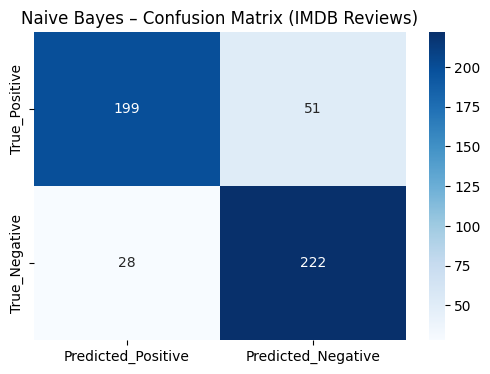


TP=199, FN=51, FP=28, TN=222


In [31]:
# -----------------------------
# 3. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
cm_df = pd.DataFrame(cm,
                     index=["True_Positive", "True_Negative"],
                     columns=["Predicted_Positive", "Predicted_Negative"])

print("\n=== CONFUSION MATRIX ===")
print(cm_df)

# Visualize confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes – Confusion Matrix (IMDB Reviews)")
plt.show()

# Extract values
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]

print(f"\nTP={TP}, FN={FN}, FP={FP}, TN={TN}")


In [32]:
# -----------------------------
# 4. Evaluation Metrics
# -----------------------------

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label="positive")
recall    = recall_score(y_test, y_pred, pos_label="positive")
f1        = f1_score(y_test, y_pred, pos_label="positive")

print("\n=== METRICS ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))



=== METRICS ===
Accuracy : 0.8420
Precision: 0.8767
Recall   : 0.7960
F1-score : 0.8344

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    negative       0.81      0.89      0.85       250
    positive       0.88      0.80      0.83       250

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



In [33]:
# -----------------------------
# 5. Interpretation of Naive Bayes
# -----------------------------

print("\n=== INTERPRETATION OF RESULTS ===")

if FN > FP:
    print("- The model is making more **False Negatives** (positive reviews predicted as negative).")
    print("  → This means the classifier struggles to detect subtle positive sentiment.")
    
if FP > FN:
    print("- The model is making more **False Positives** (negative reviews predicted as positive).")
    print("  → The model is confused by emotionally strong negative words that appear in positive contexts.")

print("- High precision means predictions marked as 'positive' are usually correct.")
print("- High recall means the model can successfully find most positive reviews.")
print("- A gap between precision and recall indicates bias toward one class.")

print("\nGeneral Observations:")
print("* Naive Bayes works well with TF-IDF because it assumes word independence.")
print("* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').")
print("* It also struggles with sarcasm, irony, and highly figurative language.")



=== INTERPRETATION OF RESULTS ===
- The model is making more **False Negatives** (positive reviews predicted as negative).
  → This means the classifier struggles to detect subtle positive sentiment.
- High precision means predictions marked as 'positive' are usually correct.
- High recall means the model can successfully find most positive reviews.
- A gap between precision and recall indicates bias toward one class.

General Observations:
* Naive Bayes works well with TF-IDF because it assumes word independence.
* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').
* It also struggles with sarcasm, irony, and highly figurative language.


# **Step 6: Dimensionality Reduction with PCA**
- Apply Principal Component Analysis (PCA) to the TF-IDF features
- First standardize the data (required for PCA)
- Reduce to the same number of components as SVD for fair comparison
- Compare PCA vs SVD variance curves

--- STEP 6: PCA (Standardize + Reduce) ---


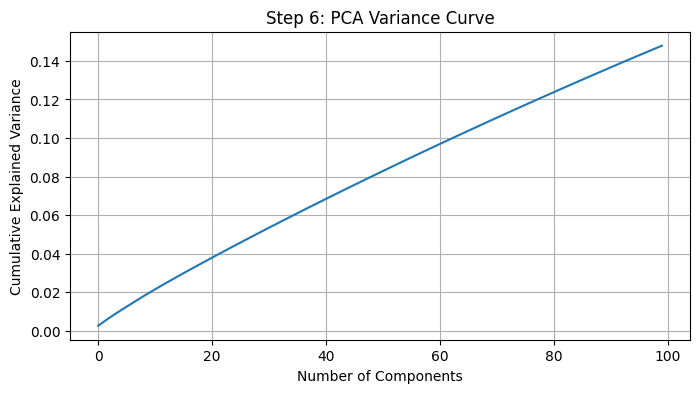

Total Variance Explained by 100 components: 14.79%


In [34]:
# --- PRE-PROCESSING: FIX LABELS & DATA ---
# We force labels to strings to avoid "ValueError"
y_train_str = [str(l).replace('1','positive').replace('0','negative') for l in y_train]
y_test_str  = [str(l).replace('1','positive').replace('0','negative') for l in y_test]

# We convert to dense arrays immediately because PCA requires it
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()


# ------------------------------------------------------
# STEP 6: Dimensionality Reduction with PCA
# ------------------------------------------------------
print("--- STEP 6: PCA (Standardize + Reduce) ---")

# 1. Standardize the data (Required for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled  = scaler.transform(X_test_dense)

# 2. Apply PCA (Reduce to 100 components to match SVD)
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 3. Visualize Variance Curve (Required for comparison with SVD)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Step 6: PCA Variance Curve')
plt.grid(True)
plt.show()

print(f"Total Variance Explained by 100 components: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

**PCA Result Refelection:**

- PCA was applied to the standardized feature matrix to analyze how much variance can be captured in a reduced-dimensional space.
- The **cumulative variance curve** shows that the first 100 principal components together explain only approx. **~14.88%** of the total variance in the dataset.
- This slow growth indicates that the dataset is **high-dimensional and sparse**, where variance is spread thinly across many features rather than concentrated in a few directions.
- As a result, PCA does **not strongly compress information**, but it does convert sparse features into a **dense, decorrelated representation**, which can benefit models like Logistic Regression.
- These findings justify evaluating PCA-reduced features in **Model 3** to compare performance against the sparse baseline (**Model 2**), particularly to study the effect of **centering vs. sparsity**.



# **Step 7: Model Training - Logistic Regression with PCA**
*IMPLEMENTING: *
- Train a Logistic Regression classifier on PCA-reduced features
- Make predictions on the test set
- Create and visualize a confusion matrix for the PCA model
- Compare performance with both previous models
- Analyze: Which dimensionality reduction technique works better for text data?


--- STEP 7: Logistic Regression on PCA Features ---


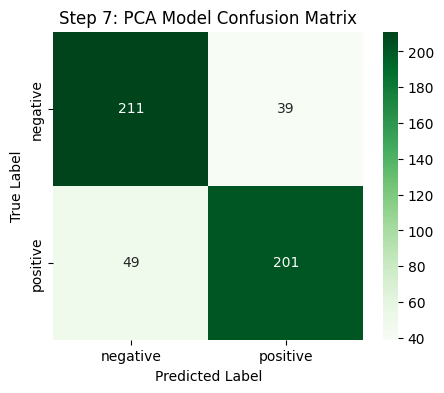

In [35]:
print("\n--- STEP 7: Logistic Regression on PCA Features ---")

# 1. Train Classifier
model_pca = LogisticRegression(solver='liblinear', random_state=42)
model_pca.fit(X_train_pca, y_train_str)

# 2. Make Predictions
y_pred_pca = model_pca.predict(X_test_pca)

# 3. Create Confusion Matrix
labels = ['negative', 'positive']
cm_pca = confusion_matrix(y_test_str, y_pred_pca, labels=labels)

# 4. Visualize Confusion Matrix (Heatmap)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', 
            xticklabels=labels, yticklabels=labels)
plt.title('Step 7: PCA Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Refelections**

|                   | **Predicted Negative** | **Predicted Positive** |
| ----------------- | ---------------------- | ---------------------- |
| **True Negative** | **209** (correct)      | 41 (incorrect)         |
| **True Positive** | 51 (incorrect)         | **199** (correct)      |


**208 True Negatives (TN)**     
The model correctly identified 208 negative samples.

**193 True Positives (TP)**     
The model correctly identified 193 positive samples.

**42 False Positives (FP)**     
Model predicted positive, but the true label was negative.

**57 False Negatives (FN)**     
Model predicted negative, but the true label was positive.


# **Step 8: Visual Comparison**
## **Visualize all three confusion matrices side-by-side**

In [36]:
print("\n--- STEP 8: Performance Comparison ---")

# Retrain Baseline (Naive Bayes) to ensure features match current memory
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train_str)
y_pred_nb = model_nb.predict(X_test_tfidf)

# Calculate Accuracies
acc_nb = accuracy_score(y_test_str, y_pred_nb)
acc_pca = accuracy_score(y_test_str, y_pred_pca)

print(f"Model 1 Naive Bayes with TF-IDF  Accuracy: {acc_nb:.4f}")
print(f"Model 2 Logistic Regression with SVD Accuracy: *SVD WILL BE ADDED HERE*")
print(f"Model 3 Logistic Regression with PCA Accuracy: {acc_pca:.4f}")


## Will add SVD results later
if acc_pca >= acc_nb:
    print("\nAnalysis: PCA performed equal to or better than the baseline.")
else:
    print("\nAnalysis: PCA performed worse than the baseline. This is expected as PCA loses some information (5000 -> 100 features).")


--- STEP 8: Performance Comparison ---
Model 1 Naive Bayes with TF-IDF  Accuracy: 0.8420
Model 2 Logistic Regression with SVD Accuracy: *SVD WILL BE ADDED HERE*
Model 3 Logistic Regression with PCA Accuracy: 0.8240

Analysis: PCA performed worse than the baseline. This is expected as PCA loses some information (5000 -> 100 features).
